In [13]:
'''
I test the performance of an AE model to predcit anomalous bottle images.
AUC looks pretty good with the mean aggregation method (max does not work too well). 
'''
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
import analysis_ae as utils


In [14]:
#Define the paths and config of the trained model
TEST_DATA_ROOT = "/scratch/bell/dutta26/mvtec/bottle/test/"
MODEL_PATH = "/home/dutta26/codes/div2k/ae_model/autoencoder_bottles.pth"
IMAGE_SIZE = 256
LATENT_DIM = 128
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [15]:
model = utils.load_model(MODEL_PATH, LATENT_DIM, DEVICE)

#Use simple transforms for evaluation
eval_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])


Model loaded successfully from /home/dutta26/codes/div2k/ae_model/autoencoder_bottles.pth


/home/dutta26/codes/div2k/ae_model/analysis_ae.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


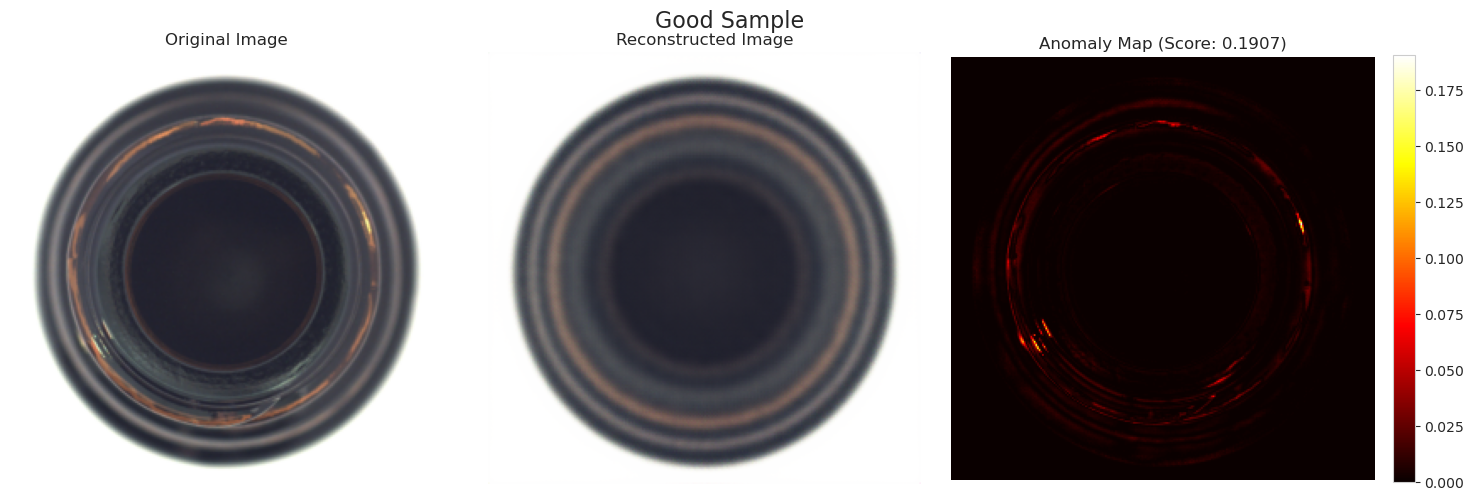

In [16]:
#Visualize some good and bad examples
good_image_path = "/scratch/bell/dutta26/mvtec/bottle/test/good/000.png"
orig, recon, anom_map, score = utils.get_anomaly_details(model, good_image_path, eval_transforms, DEVICE)
utils.plot_reconstruction_and_map(orig, recon, anom_map, score, "Good Sample")
#Notice the auto encoder does not learn reflections and shine well.
#These are categorized as anomalous region

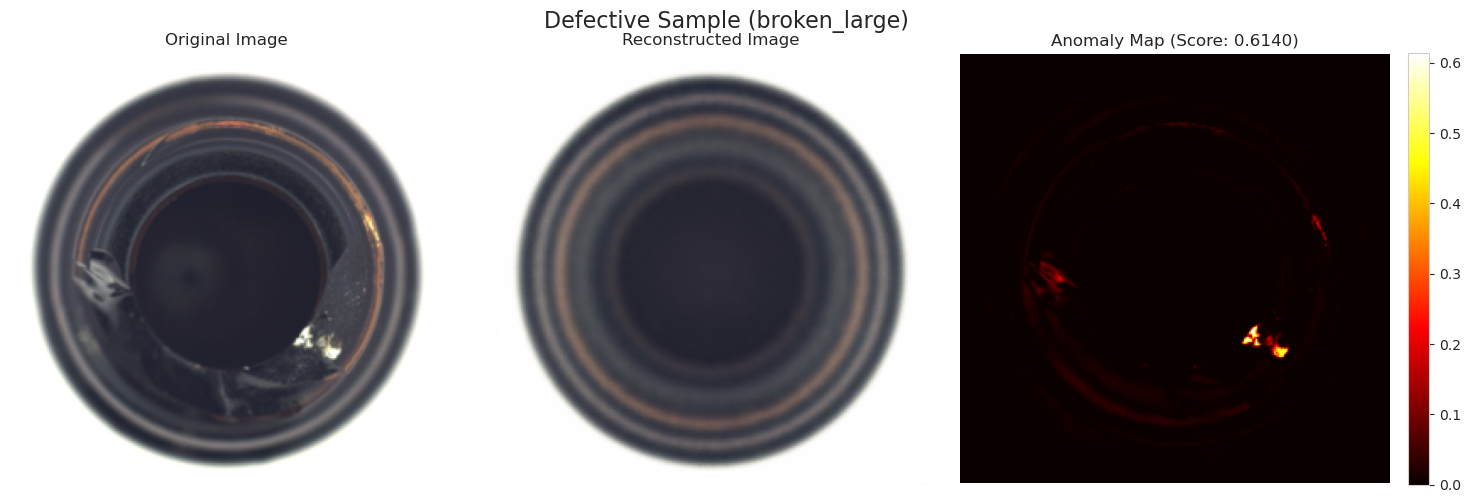

In [17]:
bad_image_path = "/scratch/bell/dutta26/mvtec/bottle/test/broken_large/001.png"
orig, recon, anom_map, score = utils.get_anomaly_details(model, bad_image_path, eval_transforms, DEVICE)
utils.plot_reconstruction_and_map(orig, recon, anom_map, score, "Defective Sample (broken_large)")
#Notice how only a small portion of the broken region light up in the anomaly map

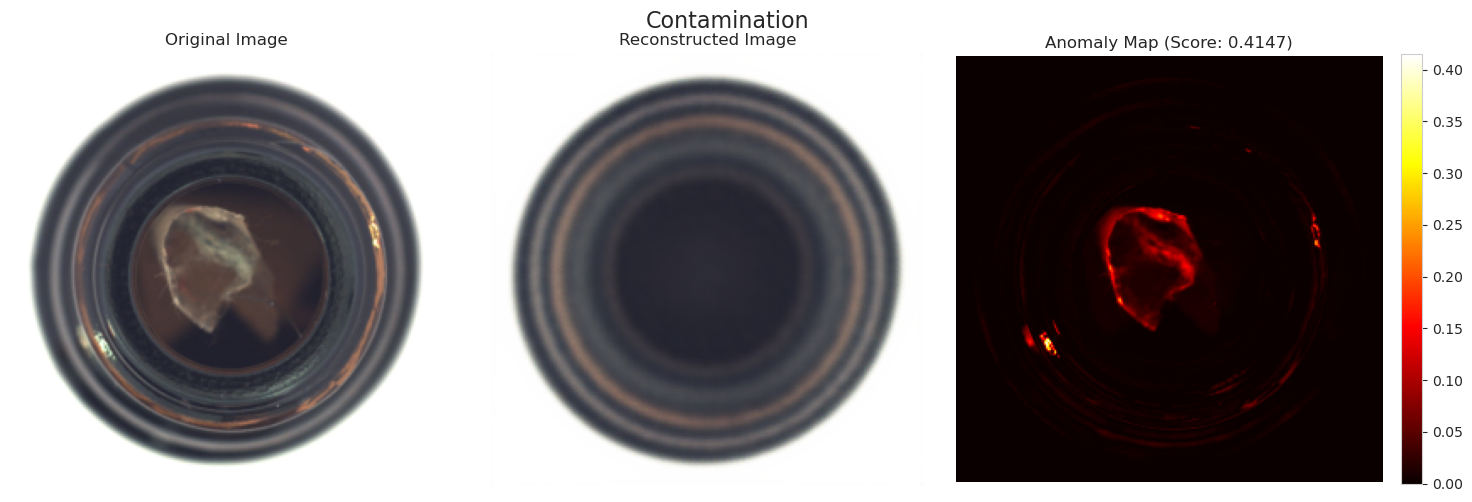

In [18]:
bad_image_path = "/scratch/bell/dutta26/mvtec/bottle/test/contamination/005.png"
orig, recon, anom_map, score = utils.get_anomaly_details(model, bad_image_path, eval_transforms, DEVICE)
utils.plot_reconstruction_and_map(orig, recon, anom_map, score, "Contamination")

In [19]:
#Testing several different aggregation methods 
results_df = utils.calculate_scores_for_dataset(model, TEST_DATA_ROOT, eval_transforms, DEVICE,  'mean')
results_df_max = utils.calculate_scores_for_dataset(model, TEST_DATA_ROOT, eval_transforms, DEVICE,  'max')

Processing category: good (20 images)
Processing category: contamination (21 images)
Processing category: broken_small (22 images)
Processing category: broken_large (20 images)
Processing category: good (20 images)
Processing category: contamination (21 images)
Processing category: broken_small (22 images)
Processing category: broken_large (20 images)
Processing category: good (20 images)
Processing category: contamination (21 images)
Processing category: broken_small (22 images)
Processing category: broken_large (20 images)


In [20]:
results_df.sample(10) #Sample of 10 

,path,label,is_defect,anomaly_score
62,/scratch/bell/dutta26/mvtec/bottle/test/broken...,broken_small,1,0.002012
28,/scratch/bell/dutta26/mvtec/bottle/test/contam...,contamination,1,0.004201
9,/scratch/bell/dutta26/mvtec/bottle/test/good/0...,good,0,0.001501
12,/scratch/bell/dutta26/mvtec/bottle/test/good/0...,good,0,0.001491
20,/scratch/bell/dutta26/mvtec/bottle/test/contam...,contamination,1,0.001689
82,/scratch/bell/dutta26/mvtec/bottle/test/broken...,broken_large,1,0.004081
0,/scratch/bell/dutta26/mvtec/bottle/test/good/0...,good,0,0.001317
74,/scratch/bell/dutta26/mvtec/bottle/test/broken...,broken_large,1,0.001746
26,/scratch/bell/dutta26/mvtec/bottle/test/contam...,contamination,1,0.002636
57,/scratch/bell/dutta26/mvtec/bottle/test/broken...,broken_small,1,0.003690


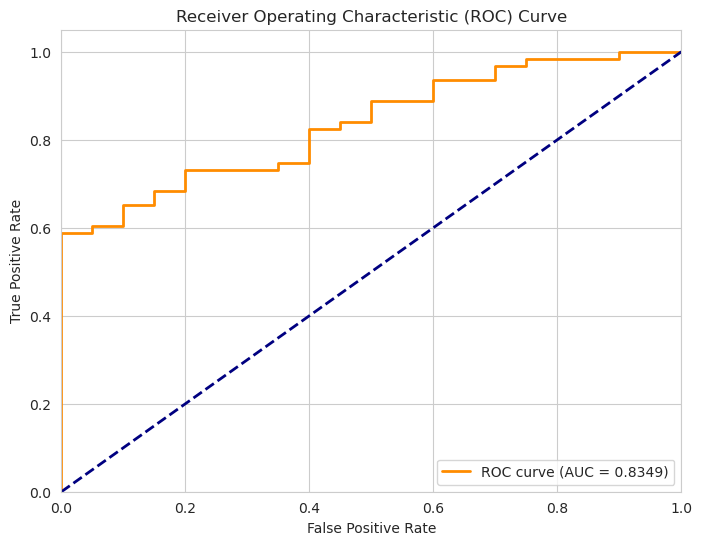

In [21]:
utils.plot_roc_curve(results_df_max) #AUC= 0.83


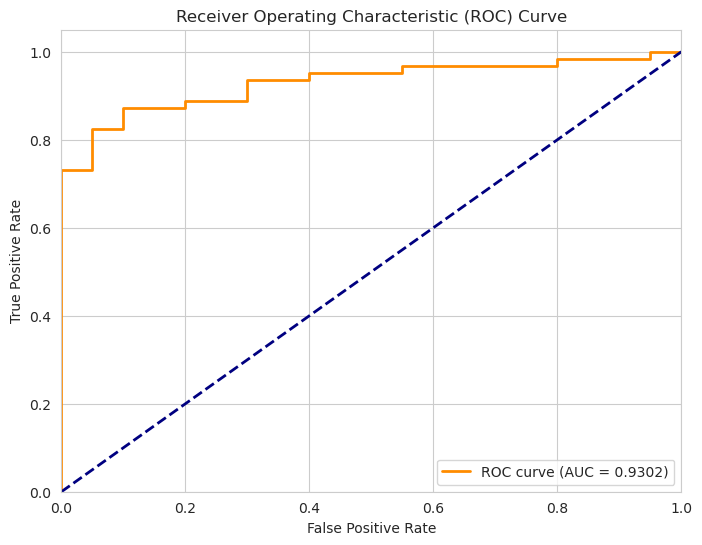

In [22]:
utils.plot_roc_curve(results_df)  #AUC = 0.93. Much  better


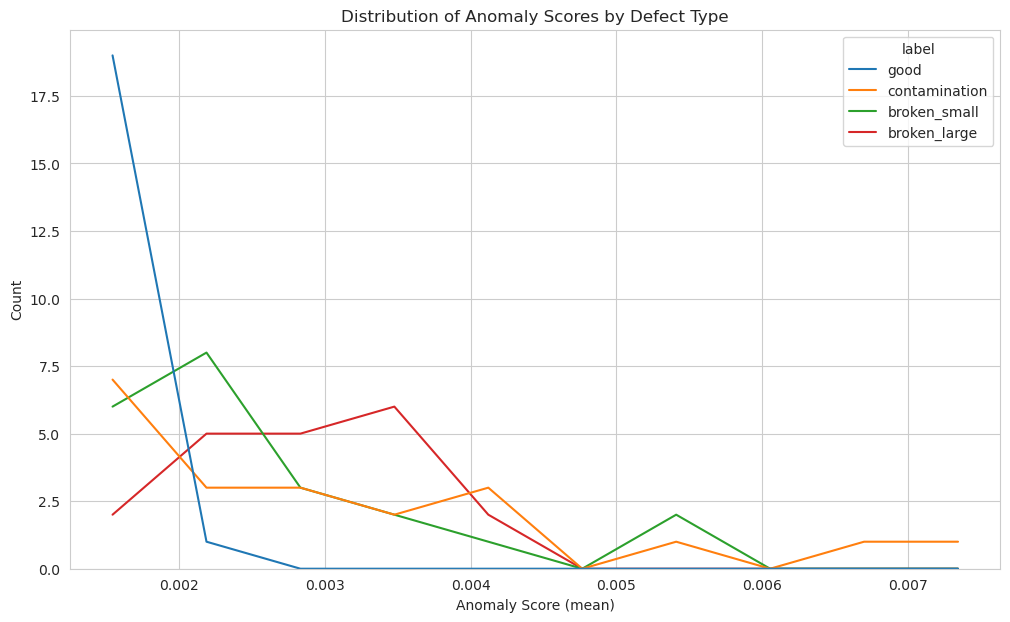

In [23]:
utils.plot_score_histograms(results_df) #Using mean anomary score since its better

Num of defective images found is 63


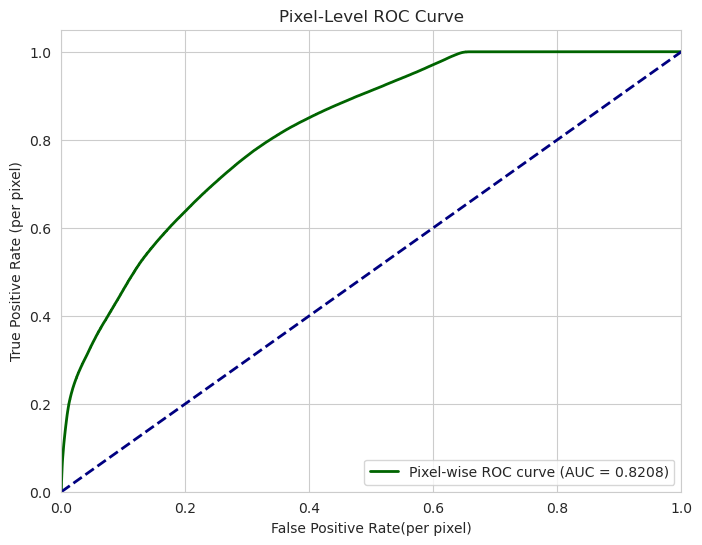

Pixel-Level AUC: 0.8208


In [24]:
#Get the pixel level AUC. 0.82 --> Room for improvement. 

GROUND_TRUTH_ROOT = "/scratch/bell/dutta26/mvtec/bottle/ground_truth/"

pixel_auc = utils.plot_pixel_roc_curve(
    model=model,
    test_data_root=TEST_DATA_ROOT,
    ground_truth_root=GROUND_TRUTH_ROOT,
    image_transforms=eval_transforms,  
    device=DEVICE
)

print(f"Pixel-Level AUC: {pixel_auc:.4f}")